# İş Problemi
Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf
(average, highlighted) oyuncu olduğunu tahminleme.

# Veri Seti Hikayesi
Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

### scoutium attributes.csv


task_response_id: Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi

match_id: İlgili maçın id'si

evaluator_id: Değerlendiricinin(scout'un) id'si

player_id: İlgili oyuncunun id'si

position_id: İlgili oyuncunun o maçta oynadığı pozisyonun id’si
###### 1: Kaleci
###### 2: Stoper
###### 3: Sağ bek
###### 4: Sol bek
###### 5: Defansif orta saha
###### 6: Merkez orta saha
###### 7: Sağ kanat
###### 8: Sol kanat
###### 9: Ofansif orta saha
###### 10: Forvet

analysis_id: Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme

attribute_id: Oyuncuların değerlendirildiği her bir özelliğin id'si

attribute_value: Bir scoutun bir oyuncunun bir özelliğine verdiği değer(puan)

### scoutium_potential_labels.csv

task_response_id: Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi

match_id: İlgili maçın id'si

evaluator_id: Değerlendiricinin(scout'un) id'si

player_id: İlgili oyuncunun id'si

potential_label: Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

# Görevler

### Adım1:
scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.

In [376]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [377]:
df_attributes = pd.read_csv('/Users/mericgenc/Desktop/Python - Data Science/Miuul Data Scientist Path/06 - Machine Learning/04_advanced_trees/01_case_study_I_scoutium/scoutium_attributes.csv', sep=';')
df_labels = pd.read_csv('/Users/mericgenc/Desktop/Python - Data Science/Miuul Data Scientist Path/06 - Machine Learning/04_advanced_trees/01_case_study_I_scoutium/scoutium_potential_labels.csv', sep=';')

In [378]:
df_attributes.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [379]:
df_attributes.shape

(10730, 8)

In [380]:
df_labels.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [381]:
df_labels.shape

(322, 5)

### Adım2:
Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştiriniz.

("task_response_id", 'match_id', 'evaluator_id' "player_id" 4 adet değişken üzerinden birleştirme işlemini gerçekleştiriniz.)

In [382]:
df = df_attributes.merge(df_labels,on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [383]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [384]:
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  \
0              4915     62935        177676    1361061            2   
1              4915     62935        177676    1361061            2   
2              4915     62935        177676    1361061            2   
3              4915     62935        177676    1361061            2   
4              4915     62935        177676    1361061            2   

   analysis_id  attribute_id  attribute_value potential_label  
0     12818495          4322             56.0         average  
1     12818495     

### Adım3:
position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.

In [385]:
df = df[~(df['position_id']==1)]

In [386]:
df['position_id'].value_counts()

2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: position_id, dtype: int64

### Adım4:
potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)

In [387]:
df = df[~(df['potential_label']=='below_average')]

In [388]:
df['potential_label'].value_counts()

average        7922
highlighted    1972
Name: potential_label, dtype: int64

In [389]:
df.groupby('potential_label').agg({'attribute_value':'mean'})

,attribute_value
potential_label,
average,54.528149
highlighted,59.514199


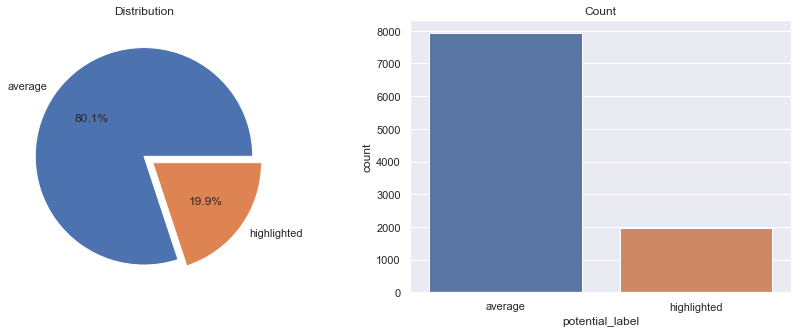

In [390]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df["potential_label"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('Distribution')
ax[0].set_ylabel('')
sns.countplot(df["potential_label"],ax=ax[1])
ax[1].set_title('Count')
plt.show()

### Adım5:
Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yapınız.

#### Adım 5.1:
İndekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturunuz.

#### Adım 5.2:
“reset_index” fonksiyonunu kullanarak indeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.

In [391]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [392]:
df_pivot = pd.pivot_table(df, values='attribute_value' ,
                          index=['player_id', 'position_id', 'potential_label'],
                          columns='attribute_id')

In [393]:
df_pivot.reset_index(inplace=True)

In [394]:
df_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [395]:
df_pivot.columns = df_pivot.columns.astype(str)

### Adım6: 
Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.

In [396]:
le = LabelEncoder()

In [397]:
df_pivot['potential_label'] = le.fit_transform(df_pivot['potential_label'])

In [398]:
df_pivot['potential_label'].unique()

array([0, 1])

In [399]:
df_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


### Adım7: 
Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.

In [400]:
num_cols = [col for col in df_pivot.columns if col not in ['player_id','position_id','potential_label']]

### Adım8: 
Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.

In [401]:
df_pivot[num_cols] = StandardScaler().fit_transform(df_pivot[num_cols])

In [402]:
df_pivot

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,0.595327,1.307560,1.373158,-0.064332,1.467260,0.722929,1.355461,...,0.786581,0.813645,0.428479,0.631718,0.198319,0.768231,1.201978,1.387369,1.762816,-0.252741
267,1907347,6,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,1.083267,1.041611
268,1909532,10,0,-0.163295,-0.932790,-0.710283,-0.811501,-0.021981,-0.035936,-0.153081,...,-0.760885,-0.583384,-0.195810,-1.620856,-1.234869,0.005628,-1.487277,-1.487256,-0.955381,-2.194269
269,1909724,2,1,1.353950,1.307560,1.373158,1.430006,1.467260,1.481795,1.355461,...,1.560314,1.512160,1.052769,0.631718,0.914913,0.768231,1.201978,1.387369,1.083267,1.041611


### Adım9: 
Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli
geliştiriniz. (Roc_auc, f1, precision, recall, accuracy metriklerini yazdırınız.)

In [403]:
#Base modelleri karşılaştıralım;

In [404]:
y = df_pivot['potential_label']
X = df_pivot.drop(['player_id','potential_label'], axis=1)

In [405]:
models = [('LR', LogisticRegression()),
            ('KNN', KNeighborsClassifier()),
            ("CART", DecisionTreeClassifier()),
            ("RF", RandomForestClassifier()),
            ('GBM', GradientBoostingClassifier()),
            ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
            ('CatBoost', CatBoostClassifier(verbose=False)),
            ("LightGBM", LGBMClassifier())]

In [406]:
for name, model in models:
    print("\n"+ name + "\n")
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, y, scoring=score, cv=10).mean()
        print(score+" score:"+str(cvs))


LR

roc_auc score:0.8452886002886002
f1 score:0.5684648684648684
precision score:0.7738095238095238
recall score:0.49000000000000005
accuracy score:0.8525132275132276

KNN

roc_auc score:0.7256998556998557
f1 score:0.4278571428571428
precision score:0.775
recall score:0.30999999999999994
accuracy score:0.8449735449735449

CART

roc_auc score:0.7181601731601732
f1 score:0.5346375846375847
precision score:0.5566666666666666
recall score:0.5399999999999999
accuracy score:0.8044973544973544

RF

roc_auc score:0.8997186147186147
f1 score:0.5928932178932179
precision score:0.9333333333333332
recall score:0.4533333333333333
accuracy score:0.8818783068783069

GBM

roc_auc score:0.8706782106782107
f1 score:0.5481529581529581
precision score:0.7633333333333333
recall score:0.4866666666666667
accuracy score:0.8560846560846562

XGBoost

roc_auc score:0.8558080808080808
f1 score:0.611030081030081
precision score:0.7397619047619048
recall score:0.5766666666666665
accuracy score:0.8563492063492063



In [407]:
# Base modelleri Cross Validation ile karşılaştıralım;

In [408]:
def base_models(X, y, scoring):
    print("Base Models....")
    models = [('LR', LogisticRegression()),
            ('KNN', KNeighborsClassifier()),
            ("CART", DecisionTreeClassifier()),
            ("RF", RandomForestClassifier()),
            ('GBM', GradientBoostingClassifier()),
            ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
            ('CatBoost', CatBoostClassifier(verbose=False)),
            ("LightGBM", LGBMClassifier())]

    for name, classifier in models:
        cv_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

scores = ["roc_auc", "f1", "precision", "recall", "accuracy"]

for i in scores:
    base_models(X, y, i)

Base Models....
roc_auc: 0.8453 (LR) 
roc_auc: 0.7257 (KNN) 
roc_auc: 0.6976 (CART) 
roc_auc: 0.8918 (RF) 
roc_auc: 0.8694 (GBM) 
roc_auc: 0.8558 (XGBoost) 
roc_auc: 0.9041 (CatBoost) 
roc_auc: 0.8982 (LightGBM) 
Base Models....
f1: 0.5685 (LR) 
f1: 0.4279 (KNN) 
f1: 0.5491 (CART) 
f1: 0.5711 (RF) 
f1: 0.5904 (GBM) 
f1: 0.611 (XGBoost) 
f1: 0.5938 (CatBoost) 
f1: 0.6633 (LightGBM) 
Base Models....
precision: 0.7738 (LR) 
precision: 0.775 (KNN) 
precision: 0.5907 (CART) 
precision: 0.87 (RF) 
precision: 0.7633 (GBM) 
precision: 0.7398 (XGBoost) 
precision: 0.93 (CatBoost) 
precision: 0.8071 (LightGBM) 
Base Models....
recall: 0.49 (LR) 
recall: 0.31 (KNN) 
recall: 0.52 (CART) 
recall: 0.47 (RF) 
recall: 0.5267 (GBM) 
recall: 0.5767 (XGBoost) 
recall: 0.47 (CatBoost) 
recall: 0.5933 (LightGBM) 
Base Models....
accuracy: 0.8525 (LR) 
accuracy: 0.845 (KNN) 
accuracy: 0.8081 (CART) 
accuracy: 0.8782 (RF) 
accuracy: 0.8708 (GBM) 
accuracy: 0.8563 (XGBoost) 
accuracy: 0.8817 (CatBoost) 
accur

In [409]:
# Holdout yöntemi ve Cross Validation metoduyla modelleri karşılaştıralım;

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [411]:
for i in scores:
    base_models(X_train, y_train, i)

Base Models....
roc_auc: 0.8293 (LR) 
roc_auc: 0.7426 (KNN) 
roc_auc: 0.6947 (CART) 
roc_auc: 0.9133 (RF) 
roc_auc: 0.8845 (GBM) 
roc_auc: 0.9018 (XGBoost) 
roc_auc: 0.9195 (CatBoost) 
roc_auc: 0.8881 (LightGBM) 
Base Models....
f1: 0.5271 (LR) 
f1: 0.4876 (KNN) 
f1: 0.5474 (CART) 
f1: 0.5964 (RF) 
f1: 0.5587 (GBM) 
f1: 0.6645 (XGBoost) 
f1: 0.656 (CatBoost) 
f1: 0.5737 (LightGBM) 
Base Models....
precision: 0.6283 (LR) 
precision: 0.95 (KNN) 
precision: 0.5429 (CART) 
precision: 0.9667 (RF) 
precision: 0.6433 (GBM) 
precision: 0.7783 (XGBoost) 
precision: 0.9167 (CatBoost) 
precision: 0.7933 (LightGBM) 
Base Models....
recall: 0.47 (LR) 
recall: 0.35 (KNN) 
recall: 0.49 (CART) 
recall: 0.475 (RF) 
recall: 0.495 (GBM) 
recall: 0.635 (XGBoost) 
recall: 0.54 (CatBoost) 
recall: 0.5 (LightGBM) 
Base Models....
accuracy: 0.8429 (LR) 
accuracy: 0.8574 (KNN) 
accuracy: 0.7963 (CART) 
accuracy: 0.8706 (RF) 
accuracy: 0.8429 (GBM) 
accuracy: 0.8749 (XGBoost) 
accuracy: 0.889 (CatBoost) 
accura

In [412]:
# LightGBM ile ilerleyelim;

In [413]:
lgbm_model = LGBMClassifier()

In [414]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [415]:
cv_results = cross_validate(lgbm_model, X_train, y_train, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.8843551797040169

In [416]:
cv_results['test_precision'].mean()

0.8306349206349205

In [417]:
cv_results['test_recall'].mean()

0.5777777777777777

In [418]:
cv_results['test_f1'].mean()

0.6582399626517275

In [419]:
cv_results['test_roc_auc'].mean()

0.8746591970121382

In [420]:
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [100, 150, 200, 250, 300, 400, 500, 750, 1000, 2000, 4000, 5000, 7000, 8000, 10000],
               "colsample_bytree": [0.5, 0.7, 1],
               "max_depth": [-1, 0, 1,2,3,4,5,6]}

In [421]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accu

In [423]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 7000}

In [424]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=14).fit(X_train, y_train)

In [425]:
cv_results = cross_validate(lgbm_final, X_train, y_train, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.9027484143763213

In [426]:
cv_results['test_precision'].mean()

0.8583333333333332

In [427]:
cv_results['test_recall'].mean()

0.6888888888888889

In [428]:
cv_results['test_f1'].mean()

0.7439775910364146

In [429]:
cv_results['test_roc_auc'].mean()

0.8846498599439776

In [430]:
y_preds = lgbm_final.predict(X_test)

In [431]:
accuracy_score(y_test, y_preds)

0.9090909090909091

In [432]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.88      0.64      0.74        11

    accuracy                           0.91        55
   macro avg       0.89      0.81      0.84        55
weighted avg       0.91      0.91      0.90        55



In [433]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

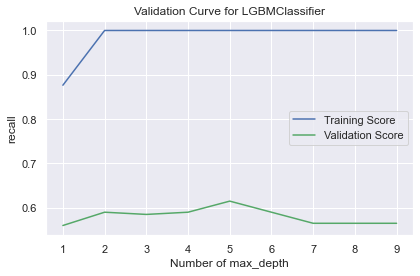

In [434]:
val_curve_params(lgbm_final, X_train, y_train, 'max_depth', range(1, 10), scoring='recall')

In [344]:
# Recall performansından dolayı bir de XGBoost'a bakalım;

In [435]:
xgboost_model = XGBClassifier()

In [436]:
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [437]:
cv_results = cross_validate(xgboost_model, X_train, y_train, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.8610993657505285

In [438]:
cv_results['test_precision'].mean()

0.7451298701298701

In [439]:
cv_results['test_recall'].mean()

0.5777777777777778

In [440]:
cv_results['test_f1'].mean()

0.6238235294117648

In [441]:
cv_results['test_roc_auc'].mean()

0.8729225023342672

In [443]:
xgboost_params = {"learning_rate": [0.1, 0.01, 0.02, 0.05],
                  "max_depth": [1,2,3,4,5,6,7,8, None],
                  "n_estimators": [100, 150, 200, 250, 300, 400, 500, 1000, 2000, 3000, 5000, 7500, 10000],
                  "colsample_bytree": [None, 0.5, 0.7, 1]}

In [444]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1872 candidates, totalling 9360 fits


In [455]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 400}

In [456]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_).fit(X_train, y_train)

In [457]:
cv_results = cross_validate(xgboost_final, X_train, y_train, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.8890063424947146

In [458]:
cv_results['test_precision'].mean()

0.9178571428571429

In [459]:
cv_results['test_recall'].mean()

0.5333333333333334

In [460]:
cv_results['test_f1'].mean()

0.6556399482870072

In [461]:
cv_results['test_roc_auc'].mean()

0.8963398692810459

In [462]:
y_preds = xgboost_final.predict(X_test)

In [463]:
accuracy_score(y_test, y_preds)

0.8727272727272727

In [464]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        44
           1       1.00      0.36      0.53        11

    accuracy                           0.87        55
   macro avg       0.93      0.68      0.73        55
weighted avg       0.89      0.87      0.85        55



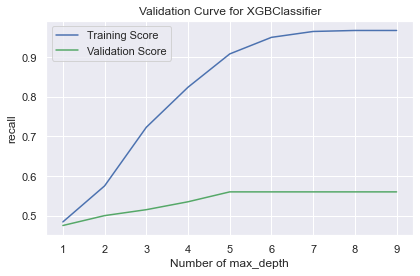

In [465]:
val_curve_params(xgboost_final, X_train, y_train, 'max_depth', range(1, 10), scoring='recall')

### Adım10:
Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.

In [466]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

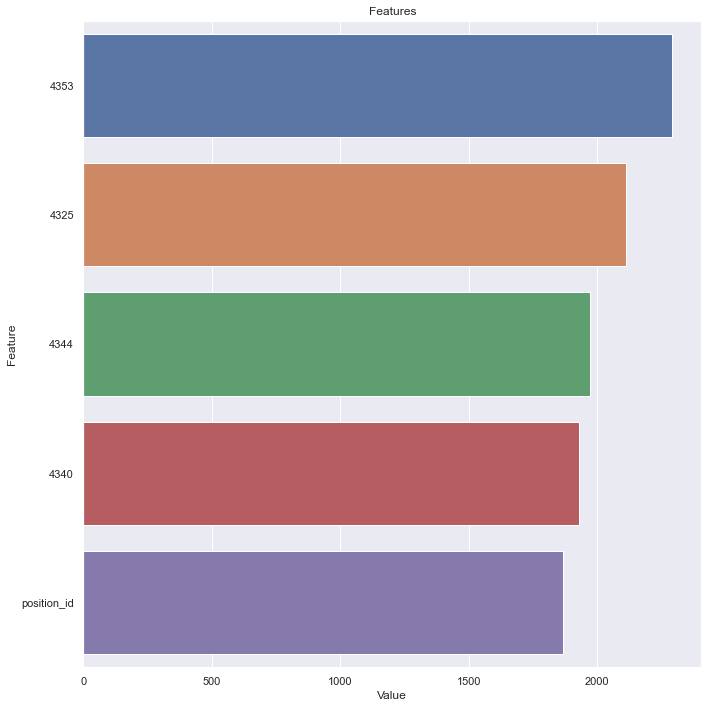

In [467]:
plot_importance(lgbm_final, X, 5)

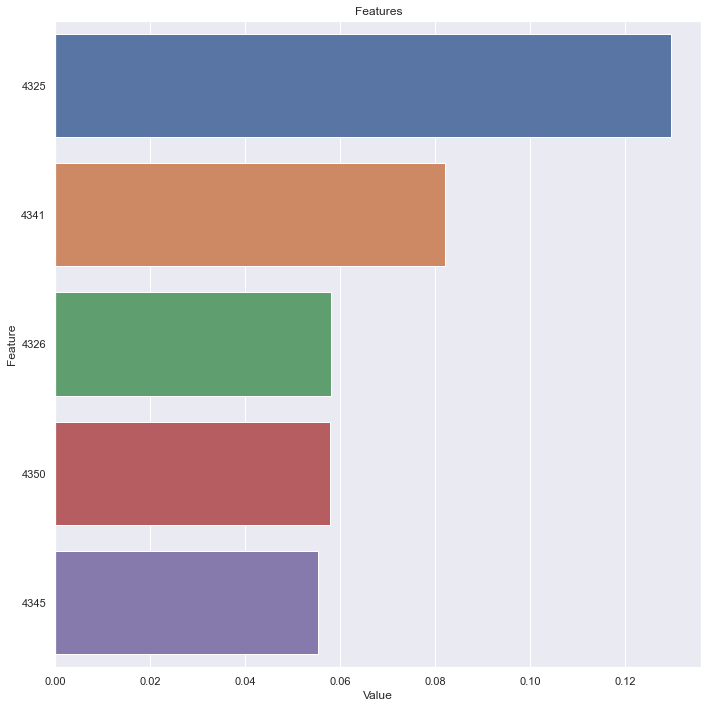

In [468]:
plot_importance(xgboost_final, X, 5)